In [59]:
from itertools import product

import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import re
import spacy.lang.ro.stop_words as stop_words
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr, kendalltau
import seaborn as sns
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

tqdm.pandas()

In [60]:
train_dataset = pd.read_csv("./datasets/train.csv")
validation_dataset = pd.read_csv("./datasets/val.csv")
test_dataset = pd.read_csv("./datasets/test.csv")

In [61]:
train_dataset

,id,text,score
0,196112,A sandwich and french bread sit on a cutting b...,-0.666667
1,514558,A baseball player is standing on the field whi...,0.000000
2,54244,A casserole served at a restaurant in a brown ...,1.333333
3,9420,OLD BLACK AND WHITE PHOTO OF AN ALL BOYS SCHOOL,1.666667
4,531512,A woman is milking a cow in the animal stable.,0.250000
...,...,...,...
7995,419064,A fire hydrant that is silver with a red top a...,1.200000
7996,344521,"A plate is filled with broccoli, apples, straw...",1.000000
7997,33652,A homemade pizza is shown with cheese and chic...,1.444444
7998,108123,The baseball player hits the ball with a stron...,-0.125000


# Score distribution

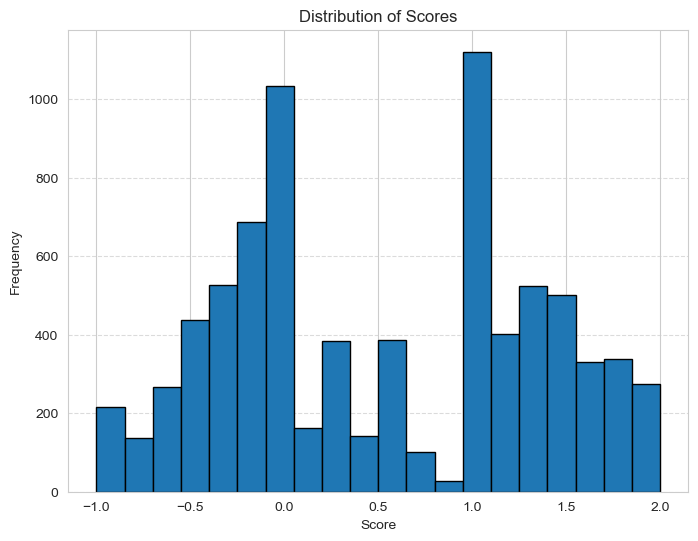

In [62]:
plt.figure(figsize=(8, 6))
plt.hist(train_dataset['score'], bins=20, edgecolor='black', alpha=1)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [63]:
# nlp = spacy.load("en_core_web_sm")

# Compile the regular expression pattern
pattern = re.compile(r"[^a-z ]")

# Convert stop words list to a set for faster lookup
sw_set = set(stop_words.STOP_WORDS)
sw_lower = set(word.lower() for word in stop_words.STOP_WORDS)

def text_preparetion(sentence):
    # 1. Lowercase everything
    sentence = sentence.lower()

    # 2. Remove all symbols other than a-z@#.
    # sentence = re.sub(pattern, " ", sentence)

    # Tokenize the preprocessed sentence
    # tokenization = nlp(sentence)
    # 
    # # 4. Remove stopwords and empty tokens, and perform stemming
    # list_text_preprocessed = [
    #     token.text for token in tokenization if 
    #     not token.is_stop and 
    #     token.pos_ != "SPACE"
    # ]
    # for token in tokenization:
    #     print(
    #         f"Text: {token.text}, Lemma: {token.lemma_}, POS Tag: {token.pos_}, Dependency: {token.dep_}, "
    #         f"Stop Word?: {token.is_stop}, Entity Type: {token.ent_type_}"
    #     )
    # Join the stemmed tokens back into a sentence
    # processed_text = ' '.join(list_text_preprocessed)

    return sentence

sentence1 = "A World War II-era bomber flying out of formation"
text_preparetion(sentence1)

'a world war ii-era bomber flying out of formation'

In [64]:
train_dataset['preprocessed_text'] = train_dataset['text'].progress_apply(text_preparetion)
validation_dataset['preprocessed_text'] = validation_dataset['text'].progress_apply(text_preparetion)
test_dataset['preprocessed_text'] = test_dataset['text'].progress_apply(text_preparetion)

100%|██████████| 500/500 [00:00<00:00, 492636.13it/s]


In [65]:
vectorizer = TfidfVectorizer(
    input="content",          # Process raw text (default)
    encoding="utf-8",         # Ensure correct text encoding
    decode_error="replace",   # Replace encoding errors
    strip_accents="unicode",  # Remove accents for better token consistency
    lowercase=True,           # Convert to lowercase
    analyzer="word",          # Analyze at the word level
    token_pattern=r"(?u)\b\w\w+\b",  # Use default tokenization pattern
    ngram_range=(1, 3),       # Include unigrams, bigrams, and trigrams for richer context
    max_df=0.9,               # Ignore terms that appear in more than 90% of documents (common words)
    min_df=3,                 # Include terms appearing in at least 3 documents (remove rare noise)
    max_features=1000,        # Increase feature limit for more comprehensive representation
    stop_words="english",     # Remove common English stop words
    binary=False,             # Use term frequency instead of binary counts
    dtype=np.float32,         # Use float32 for memory efficiency
    norm="l2",                # Normalize TF-IDF vectors to unit length (L2 norm)
    use_idf=True,             # Use inverse document frequency
    smooth_idf=True,          # Smooth IDF weights to avoid division by zero
    sublinear_tf=True         # Apply sublinear scaling (logarithmic) to term frequencies
)

X_train = vectorizer.fit_transform(train_dataset["text"].values)
# X = X.toarray()

X_validation = vectorizer.transform(validation_dataset["text"].values)
X_test = vectorizer.transform(test_dataset["text"].values)
# X_validation = X_validation.toarray()

y_train = train_dataset["score"].values
y_validation = validation_dataset["score"].values

In [66]:
# scaler = StandardScaler(with_mean=False)
# 
# X_train = scaler.fit_transform(X_train)
# 
# X_validation = scaler.transform(X_validation)
# X_test = scaler.transform(X_test)

# Sentences distribution

In [67]:
pca = PCA(n_components=3)
reduced_pca = pca.fit_transform(X_train)

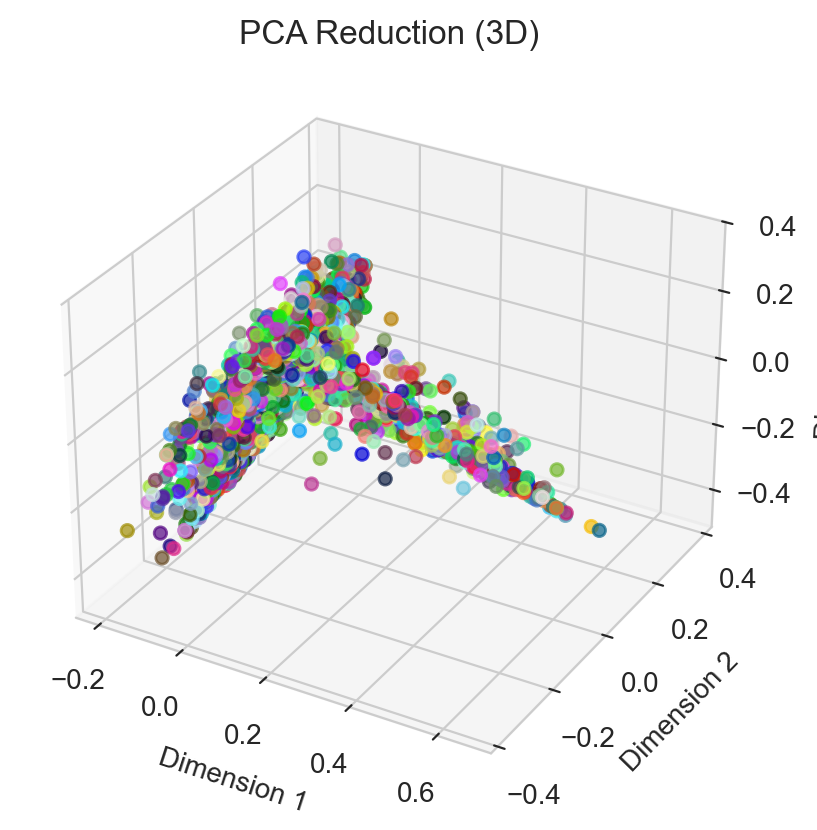

In [68]:
num_sentences = X_train.shape[0]
colors = np.random.rand(num_sentences, 3)

def plot_3d(data, title, color='blue'):
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], alpha=0.7, c=colors)
    ax.set_title(title)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    plt.show()

# Plot PCA
plot_3d(reduced_pca, "PCA Reduction (3D)")

In [69]:
best_model = None
results = []

# SVR

In [70]:
# Calculate weights based on score frequency
unique, counts = np.unique(y_train, return_counts=True)
weights = 1 / counts
weight_dict = dict(zip(unique, weights))
sample_weights = np.array([weight_dict[score] for score in y_train])

In [71]:
C_values = [0.1, 1, 10, 100]
epsilon_values = [0.01, 0.1, 1]
kernels = ['rbf']

param_combination = list(product(C_values, epsilon_values, kernels))

best_mse = 100.0
for C, epsilon, kernel in tqdm(param_combination):
    model = SVR(kernel=kernel, C=C, epsilon=epsilon)
    model.fit(X_train, y_train, sample_weight=sample_weights)
    
    y_pred = model.predict(X_validation)
    mse = mean_squared_error(y_validation, y_pred)
    mae = mean_absolute_error(y_validation, y_pred)
    spearman_corr, _ = spearmanr(y_validation, y_pred)
    kendall_corr, _ = kendalltau(y_validation, y_pred)
    
    result = {
        "Model": "SVR",
        "MAE": float(round(mae, 2)),
        "MSE": float(round(mse, 2)),
        "Spearman Correlation": float(round(spearman_corr, 2)),
        "Kendall Correlation": float(round(kendall_corr, 2)),
        "C": C,
        "Epsilon": epsilon,
    }
    
    if mse < best_mse:
        best_model = model
        best_mse = mse

    # print(result)
    results.append(result)

100%|██████████| 12/12 [00:24<00:00,  2.03s/it]


# Linear Regresion

In [72]:
model = LinearRegression(n_jobs=8)
model.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = model.predict(X_validation)
mse = mean_squared_error(y_validation, y_pred)
mae = mean_absolute_error(y_validation, y_pred)
spearman_corr, _ = spearmanr(y_validation, y_pred)
kendall_corr, _ = kendalltau(y_validation, y_pred)

result = {
    "Model": "Linear Regression",
    "MAE": float(round(mae, 2)),
    "MSE": float(round(mse, 2)),
    "Spearman Correlation": float(round(spearman_corr, 2)),
    "Kendall Correlation": float(round(kendall_corr, 2)),
}

if mse < best_mse:
    best_model = model

results.append(result)

# Decision Tree Regressor

In [73]:
max_depth_values = [3, 5, 10, None]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 5]

param_combination = list(product(max_depth_values, min_samples_split_values, min_samples_leaf_values))

for max_depth, min_samples_split, min_samples_leaf in tqdm(param_combination):
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train, sample_weight=sample_weights)
    
    y_pred = model.predict(X_validation)
    mse = mean_squared_error(y_validation, y_pred)
    mae = mean_absolute_error(y_validation, y_pred)
    spearman_corr, _ = spearmanr(y_validation, y_pred)
    kendall_corr, _ = kendalltau(y_validation, y_pred)
    
    result = {
        "Model": "Decision Tree Regressor",
        "MAE": float(round(mae, 2)),
        "MSE": float(round(mse, 2)),
        "Spearman Correlation": float(round(spearman_corr, 2)),
        "Kendall Correlation": float(round(kendall_corr, 2)),
        "Max Depth": max_depth,
        "Min Samples Split": min_samples_split,
        "Min Samples Leaf": min_samples_leaf,
    }
    
    if mse < best_mse:
        best_model = model
        best_mse = mse
    
    results.append(result)

# # Visualizing the Decision Tree
# plt.figure(figsize=(15, 10))
# tree.plot_tree(model, filled=True, feature_names=X_train.columns.tolist() if hasattr(X_train, 'columns') else None, rounded=True,fontsize=10)
# plt.title("Decision Tree Visualization")
# plt.show()
# 
# # Feature Importance
# feature_importances = pd.DataFrame({
#     'Feature': X_train.columns.tolist() if hasattr(X_train, 'columns') else range(X_train.shape[1]),
#     'Importance': model.feature_importances_
# }).sort_values(by='Importance', ascending=False)
# 
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
# plt.title("Feature Importance")
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.show()

100%|██████████| 36/36 [00:04<00:00,  8.36it/s]


# Random Forest Regressor

In [74]:
n_estimators_values = [10, 50, 100]
max_depth_values = [3, 5, 10, None]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 5]

param_combination = list(product(n_estimators_values, max_depth_values, min_samples_split_values, min_samples_leaf_values))


for n_estimators, max_depth, min_samples_split, min_samples_leaf in tqdm(param_combination):
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train, sample_weight=sample_weights)

    y_pred = model.predict(X_validation)
    mse = mean_squared_error(y_validation, y_pred)
    mae = mean_absolute_error(y_validation, y_pred)
    spearman_corr, _ = spearmanr(y_validation, y_pred)
    kendall_corr, _ = kendalltau(y_validation, y_pred)

    result = {
        "Model": "Random Forrest Regressor",
        "MAE": float(round(mae, 2)),
        "MSE": float(round(mse, 2)),
        "Spearman Correlation": float(round(spearman_corr, 2)),
        "Kendall Correlation": float(round(kendall_corr, 2)),
        "N Estimators": n_estimators,
        "Max Depth": max_depth,
        "Min Samples Split": min_samples_split,
        "Min Samples Leaf": min_samples_leaf,
    }

    if mse < best_mse:
        best_model = model
        best_mse = mse

    results.append(result)

100%|██████████| 108/108 [07:59<00:00,  4.44s/it]


# Results

In [80]:
results_df = pd.DataFrame(results)
results_df.fillna("", inplace=True)
results_df.sort_values(by="MSE", inplace=True)
results_df

,Model,MAE,MSE,Spearman Correlation,Kendall Correlation,C,Epsilon,Max Depth,Min Samples Split,Min Samples Leaf,N Estimators
10,SVR,0.52,0.45,0.58,0.41,100.0,0.1,,,,
149,Random Forrest Regressor,0.54,0.45,0.57,0.40,,,,2.0,2.0,100.0
116,Random Forrest Regressor,0.54,0.46,0.56,0.39,,,,5.0,2.0,50.0
118,Random Forrest Regressor,0.53,0.46,0.56,0.39,,,,10.0,1.0,50.0
148,Random Forrest Regressor,0.53,0.46,0.56,0.39,,,,2.0,1.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...
41,Decision Tree Regressor,0.70,0.82,0.37,0.25,,,,2.0,2.0,
43,Decision Tree Regressor,0.69,0.82,0.38,0.27,,,,5.0,1.0,
46,Decision Tree Regressor,0.70,0.83,0.36,0.25,,,,10.0,1.0,
47,Decision Tree Regressor,0.71,0.83,0.35,0.24,,,,10.0,2.0,


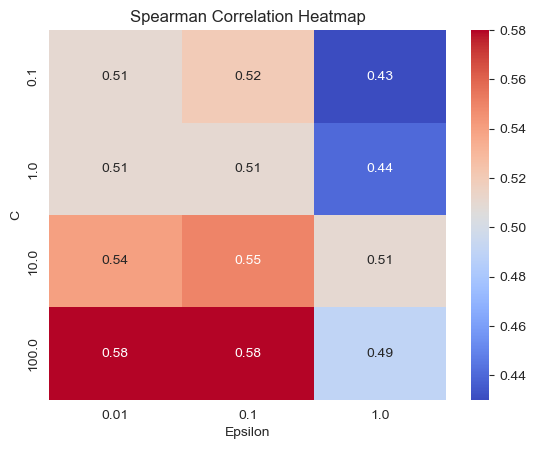

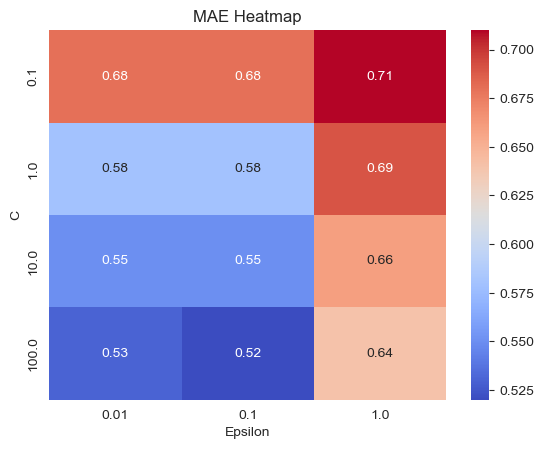

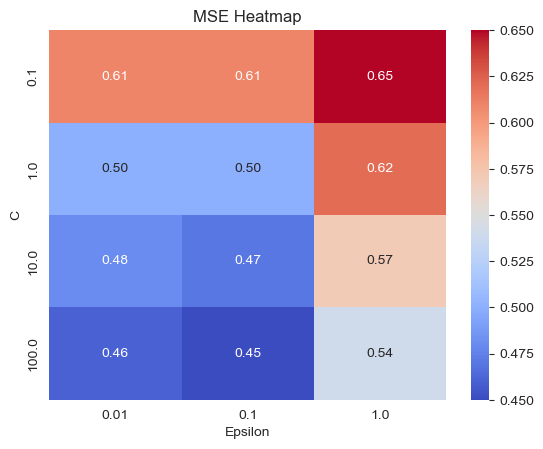

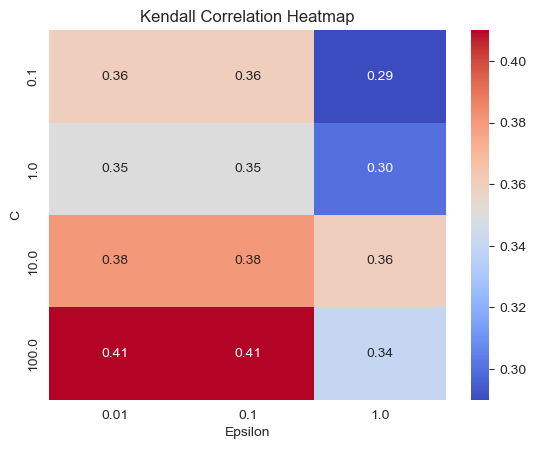

In [76]:
# Pivot table for Spearman Correlation
spearman_pivot = results_df[results_df['Model'] == "SVR"].pivot(index="C", columns="Epsilon", values="Spearman Correlation")

# Plot heatmap for Spearman Correlation
sns.heatmap(spearman_pivot, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Spearman Correlation Heatmap")
plt.show()

# Pivot table for MAE
mae_pivot = results_df[results_df['Model'] == "SVR"].pivot(index="C", columns="Epsilon", values="MAE")

# Plot heatmap for MAE
sns.heatmap(mae_pivot, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("MAE Heatmap")
plt.show()

# Pivot table for MSE
mse_pivot = results_df[results_df['Model'] == "SVR"].pivot(index="C", columns="Epsilon", values="MSE")

# Plot heatmap for MSE
sns.heatmap(mse_pivot, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("MSE Heatmap")
plt.show()

# Pivot table for Kendall Correlation
kendall_pivot = results_df[results_df['Model'] == "SVR"].pivot(index="C", columns="Epsilon", values="Kendall Correlation")

# Plot heatmap for Kendall Correlation
sns.heatmap(kendall_pivot, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Kendall Correlation Heatmap")
plt.show()


# Test

In [77]:
test_dataset["score"] = best_model.predict(X_test)

In [78]:
test_dataset.drop(["text", "preprocessed_text"], axis=1, inplace=True)

In [79]:
test_dataset.to_csv("./submissions/submission.csv", index=False)